In [59]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [60]:
df = pd.read_csv("df_with_emotions.csv")

In [61]:
X = df.drop(columns=['Mental_Health_Status', 'Daily_Reflections', 'Stress_Level', 'Depression_Score', 'Anxiety_Score'])
Y = df['Mental_Health_Status']
X.head()

,Age,Gender,GPA,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,0.483148,-0.963883,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,1.000000,0.000000
1,-0.601579,1,-0.138201,-0.633426,-0.566872,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,0.000000,1.000000
2,0.279210,0,1.400826,1.468360,0.793510,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,0.250000,0.250000
3,-1.041973,1,-1.501896,1.402679,-0.263157,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,0.000000,0.500000
4,-0.601579,2,0.115057,-0.107979,-1.201176,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.153846,0.153846


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [63]:
model = LogisticRegression(random_state=42, solver='lbfgs')
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [200, 500, 1000]
}

In [64]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.0001, 0.001, ...], 'max_iter': [200, 500, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,penalty,'l2'


In [65]:
results = pd.DataFrame(grid_search.cv_results_)

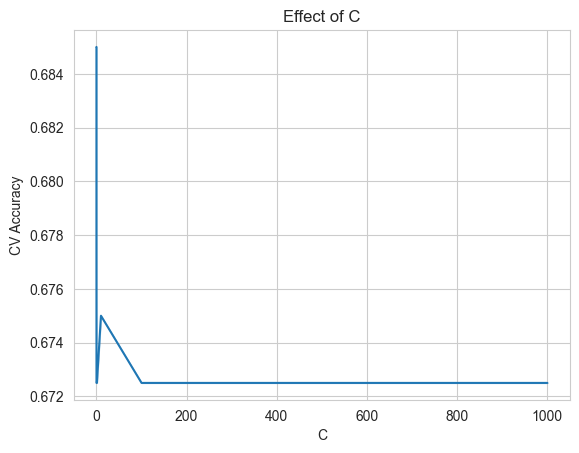

In [66]:
sns.lineplot(x='param_C', y='mean_test_score', data=results)
plt.title("Effect of C")
plt.ylabel("CV Accuracy")
plt.xlabel("C")
plt.show()

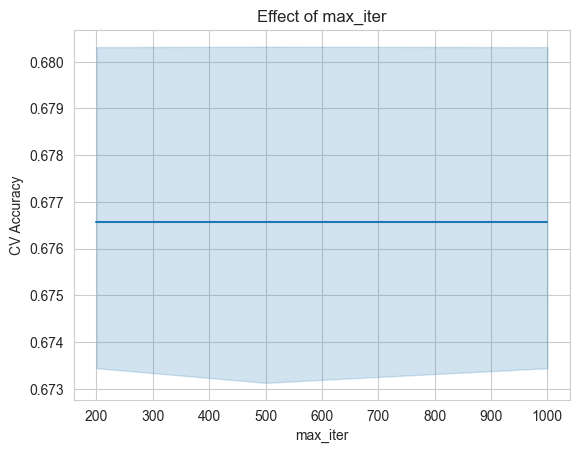

In [67]:
sns.lineplot(x='param_max_iter', y='mean_test_score', data=results)
plt.title("Effect of max_iter")
plt.ylabel("CV Accuracy")
plt.xlabel("max_iter")
plt.show()

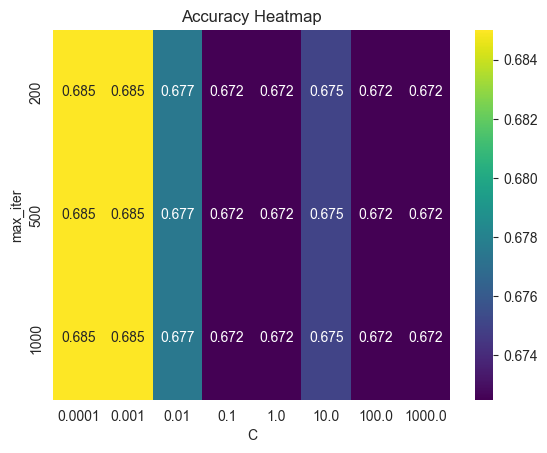

In [68]:
pivot = results.pivot_table(index='param_max_iter',
                             columns='param_C',
                             values='mean_test_score')

sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Accuracy Heatmap")
plt.xlabel("C")
plt.ylabel("max_iter")
plt.show()

In [69]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [70]:
best_params_list = []
test_scores = []

In [71]:
for train_idx, test_idx in outer_cv.split(X, Y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))  # increase max_iter
    ])

    param_grid = {
        'logreg__C': [0.1, 1, 10],
        'logreg__penalty': ['l2'],
        'logreg__solver': ['lbfgs']
    }

    grid = GridSearchCV(pipe, param_grid, cv=inner_cv)
    grid.fit(X_train, y_train)

    best_params_list.append(grid.best_params_)

    test_score = grid.score(X_test, y_test)
    test_scores.append(test_score)

In [72]:
print("Test scores per fold:", test_scores)
print("Average nested CV score:", np.mean(test_scores))

param_counter = Counter(tuple(sorted(bp.items())) for bp in best_params_list)
most_common = param_counter.most_common(1)[0]

print("\nMost common best hyperparameters across folds:")
for param, value in most_common[0]:
    print(f"  {param}: {value}")
print(f"Selected in {most_common[1]} out of {len(best_params_list)} folds")

Test scores per fold: [0.69, 0.66, 0.65, 0.68, 0.66]
Average nested CV score: 0.668

Most common best hyperparameters across folds:
  logreg__C: 0.1
  logreg__penalty: l2
  logreg__solver: lbfgs
Selected in 5 out of 5 folds


In [73]:
model = LogisticRegression(random_state=42, C = 0.0001, max_iter = 200)

In [74]:
#data is already scaled
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.0001
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [75]:
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

Accuracy: 0.68


In [76]:
f1 = f1_score(y_test, y_test_pred, average='macro')
print("Macro-Averaged F1 Score:", f1)

precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)

class_labels = sorted(y_test.unique())

print("\nPrecision and Recall by Class:")
for i, label in enumerate(class_labels):
    print(f"Class {label}: Precision = {precision[i]:.3f}, Recall = {recall[i]:.3f}")

Macro-Averaged F1 Score: 0.2698412698412698

Precision and Recall by Class:
Class 0: Precision = 0.000, Recall = 0.000
Class 1: Precision = 0.000, Recall = 0.000
Class 2: Precision = 0.680, Recall = 1.000


/Users/Aysha/PycharmProjects/AI4ALL-Ignite-SU25/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Confusion Matrix: Logistic Regression


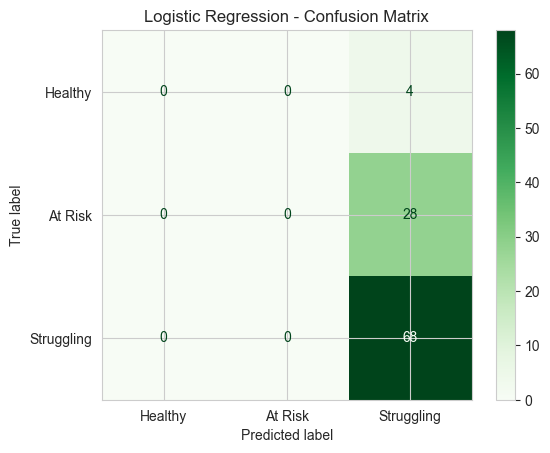

In [77]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_test_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                                 display_labels=['Healthy', 'At Risk', 'Struggling'])
print("Confusion Matrix: Logistic Regression")
disp_lr.plot(cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [78]:
import joblib
joblib.dump(model, 'logistic_model.pkl')

['logistic_model.pkl']

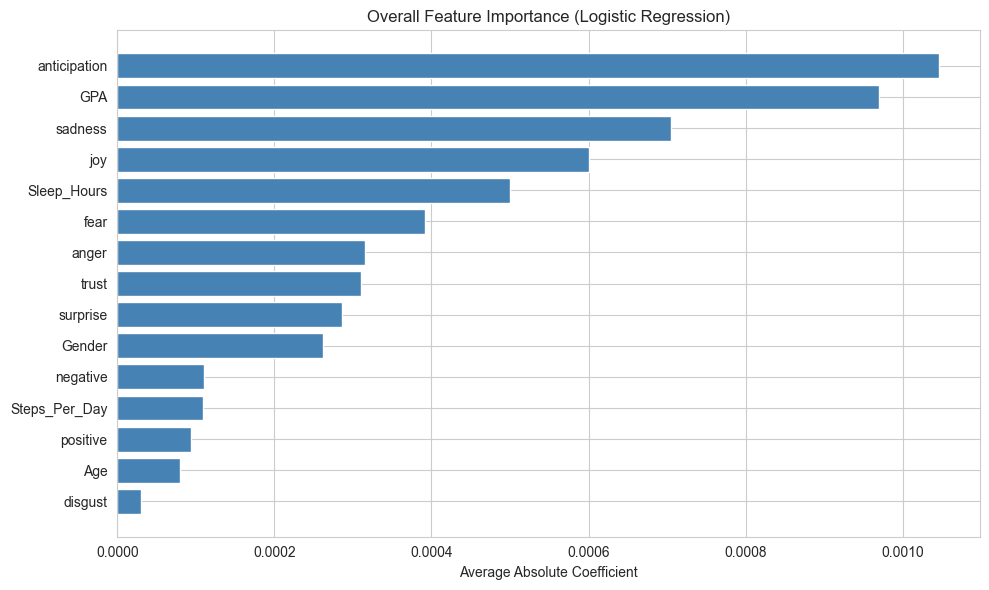

In [79]:
feature_names = X.columns
coefficients = model.coef_[0]
avg_importance = np.mean(np.abs(model.coef_), axis=0)
feature_names = X.columns
indices = np.argsort(avg_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(avg_importance)), avg_importance[indices], color="steelblue")
plt.yticks(range(len(avg_importance)), [feature_names[i] for i in indices])
plt.xlabel("Average Absolute Coefficient")
plt.title("Overall Feature Importance (Logistic Regression)")
plt.tight_layout()
plt.show()